In [1]:
import requests
from pathlib import Path
from zipfile import ZipFile
import json
import pandas as pd
from typing import Optional, List, Dict
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def download_and_process_t20(max_files: int = 500, output_dir: str = "data/processed") -> Optional[pd.DataFrame]:
    """Download and process T20 match data from cricsheet.org.
    
    Args:
        max_files: Maximum number of JSON files to process
        output_dir: Directory to save the processed CSV
        
    Returns:
        DataFrame containing processed match data or None if failed
    """
    try:
        # Set up directories
        raw_dir = Path("data/raw")
        raw_dir.mkdir(parents=True, exist_ok=True)
        Path(output_dir).mkdir(parents=True, exist_ok=True)
        
        # Download the file
        t20_link = "https://cricsheet.org/downloads/t20s_json.zip"
        logger.info(f"Downloading from: {t20_link}")
        
        response = requests.get(t20_link, timeout=30)
        response.raise_for_status()
        
        zip_path = raw_dir / "t20s_json.zip"
        with open(zip_path, 'wb') as f:
            f.write(response.content)
        
        # Extract files
        with ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(raw_dir)
        
        # Process JSON files
        all_matches = []
        json_files = list(raw_dir.glob("*.json"))[:max_files]
        
        if not json_files:
            raise ValueError("No JSON files found in the downloaded archive")
        
        logger.info(f"Processing {len(json_files)} JSON files...")
        
        for file_path in json_files:
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    match_data = json.load(f)
                
                match_info = extract_match_info(file_path.stem, match_data)
                all_matches.append(match_info)
                
            except Exception as e:
                logger.error(f"Error processing {file_path.name}: {str(e)}")
                continue
        
        if not all_matches:
            raise ValueError("No matches were successfully processed")
        
        # Create and analyze DataFrame
        df = pd.DataFrame(all_matches)
        
        logger.info("\n=== DATA SUMMARY ===")
        logger.info(f"Successfully processed {len(df)} matches")
        logger.info("\nColumns available:")
        logger.info(df.columns.tolist())
        
        # Save to CSV
        output_path = Path(output_dir) / "t20_matches_complete.csv"
        df.to_csv(output_path, index=False)
        logger.info(f"\nData saved to {output_path}")
        
        return df
        
    except requests.RequestException as e:
        logger.error(f"Network error occurred: {str(e)}")
    except Exception as e:
        logger.error(f"Unexpected error: {str(e)}", exc_info=True)
    return None

def extract_match_info(match_id: str, match_data: Dict) -> Dict:
    """Extract relevant information from a single match JSON."""
    info = match_data.get('info', {})
    outcome = info.get('outcome', {})
    toss = info.get('toss', {})
    
    match_info = {
        'match_id': match_id,
        'date': info.get('dates', [''])[0],
        'match_type': info.get('match_type', ''),
        'venue': info.get('venue', ''),
        'city': info.get('city', ''),
        'teams': ', '.join(info.get('teams', [])),
        'toss_winner': toss.get('winner', ''),
        'toss_decision': toss.get('decision', ''),
        'winner': outcome.get('winner', 'No result'),
        'result_method': outcome.get('method', ''),
        'player_of_match': ', '.join(info.get('player_of_match', [])),
        'umpires': ', '.join([umpire.get('name', '') for umpire in info.get('umpires', [])]),
        'neutral_venue': info.get('neutral_venue', False),
        'overs': info.get('overs', 20)
    }
    
    # Add innings data
    for i, inning in enumerate(match_data.get('innings', [])[:2], 1):  # Max 2 innings
        match_info[f'inning_{i}_team'] = inning.get('team', '')
        match_info[f'inning_{i}_runs'] = sum(over['deliveries'][-1]['runs']['total'] for over in inning.get('overs', []))
        match_info[f'inning_{i}_wickets'] = sum(
            1 for over in inning.get('overs', []) 
            for delivery in over['deliveries'] 
            if 'wickets' in delivery
        )
    
    return match_info

if __name__ == "__main__":
    logger.info("Starting T20 data processing...")
    result = download_and_process_t20()
    if result is not None:
        logger.info("\nOperation completed successfully!")
        logger.info(f"Total matches processed: {len(result)}")
    else:
        logger.error("\nOperation failed")

INFO:__main__:Starting T20 data processing...
INFO:__main__:Downloading from: https://cricsheet.org/downloads/t20s_json.zip
INFO:__main__:Processing 500 JSON files...
INFO:__main__:
=== DATA SUMMARY ===
INFO:__main__:Successfully processed 500 matches
INFO:__main__:
Columns available:
INFO:__main__:['match_id', 'date', 'match_type', 'venue', 'city', 'teams', 'toss_winner', 'toss_decision', 'winner', 'result_method', 'player_of_match', 'umpires', 'neutral_venue', 'overs', 'inning_1_team', 'inning_1_runs', 'inning_1_wickets', 'inning_2_team', 'inning_2_runs', 'inning_2_wickets']
INFO:__main__:
Data saved to data\processed\t20_matches_complete.csv
INFO:__main__:
Operation completed successfully!
INFO:__main__:Total matches processed: 500


In [2]:
#Quick Data Check:
import pandas as pd
df = pd.read_csv("data/processed/t20_matches_complete.csv")
print(df.head())  # Verify first few rows
print(df.isnull().sum())  # Check for missing data

   match_id        date match_type                              venue  \
0   1001349  2017-02-17        T20           Melbourne Cricket Ground   
1   1001351  2017-02-19        T20     Simonds Stadium, South Geelong   
2   1001353  2017-02-22        T20                      Adelaide Oval   
3   1004729  2016-09-05        T20  Bready Cricket Club, Magheramason   
4   1007655  2016-06-18        T20                 Harare Sports Club   

          city                 teams toss_winner toss_decision     winner  \
0          NaN  Australia, Sri Lanka   Sri Lanka         field  Sri Lanka   
1     Victoria  Australia, Sri Lanka   Sri Lanka         field  Sri Lanka   
2          NaN  Australia, Sri Lanka   Sri Lanka         field  Australia   
3  Londonderry    Ireland, Hong Kong   Hong Kong           bat  Hong Kong   
4          NaN       Zimbabwe, India       India         field   Zimbabwe   

  result_method player_of_match  umpires  neutral_venue  overs inning_1_team  \
0           NaN   

In [3]:
import pandas as pd

# Load your original data
df = pd.read_csv("data/processed/t20_matches_complete.csv") 

# Select first 500 records
df_500 = df.head(500).copy()

def clean_t20_data(df):
    """
    Comprehensive cleaning pipeline for T20 match data
    Returns cleaned DataFrame and cleaning report
    """
    cleaning_report = {}
    df_clean = df.copy()
    
    # 1. Drop completely empty columns
    empty_cols = df_clean.columns[df_clean.isna().all()].tolist()
    df_clean.drop(columns=empty_cols, inplace=True)
    cleaning_report['dropped_empty_columns'] = empty_cols
    
    # 2. Handle missing values
    fill_rules = {
        'city': 'Unknown',
        'result_method': 'standard',
        'player_of_match': 'None awarded',
        'inning_2_team': 'Incomplete',
        'inning_2_runs': 0,
        'inning_2_wickets': 0
    }
    df_clean.fillna(fill_rules, inplace=True)
    cleaning_report['filled_missing_values'] = fill_rules
    
    # 3. Clean data types
    df_clean['date'] = pd.to_datetime(df_clean['date'])
    numeric_cols = ['inning_1_runs', 'inning_2_runs', 
                   'inning_1_wickets', 'inning_2_wickets']
    df_clean[numeric_cols] = df_clean[numeric_cols].apply(pd.to_numeric, errors='coerce')
    
    # 4. Standardize text fields
    df_clean['match_type'] = df_clean['match_type'].str.upper().str.strip()
    df_clean['toss_decision'] = df_clean['toss_decision'].str.lower().str.strip()
    
    # 5. Validate scores
    df_clean = df_clean[(df_clean['inning_1_runs'] <= 300) & 
                       (df_clean['inning_2_runs'] <= 300)]
    
    # 6. Generate cleaning report
    cleaning_report['remaining_missing'] = df_clean.isna().sum().to_dict()
    cleaning_report['final_shape'] = df_clean.shape
    
    return df_clean, cleaning_report

# Clean the data
cleaned_data, report = clean_t20_data(df_500)

# Display results
print("═══════════════════════════════════════")
print("        T20 DATA CLEANING REPORT      ")
print("═══════════════════════════════════════")

print("\n█ Dropped Columns:")
print(f"{report['dropped_empty_columns']} (empty columns)")

print("\n█ Missing Values Handled:")
for col, val in report['filled_missing_values'].items():
    print(f"- {col}: filled with '{val}'")

print("\n█ Final Data Shape:")
print(f"{report['final_shape'][0]} matches with {report['final_shape'][1]} columns")

print("\n█ Remaining Missing Values:")
for col, count in report['remaining_missing'].items():
    if count > 0:
        print(f"- {col}: {count}")

print("\n═══════════════════════════════════════")
print("          FIRST 5 CLEANED MATCHES      ")
print("═══════════════════════════════════════")
print(cleaned_data.head())

print("\n═══════════════════════════════════════")
print(f"Successfully cleaned {len(cleaned_data)} matches")
print("═══════════════════════════════════════")

# To save cleaned data:
# cleaned_data.to_csv("data/processed/t20_matches_cleaned_500.csv", index=False)

═══════════════════════════════════════
        T20 DATA CLEANING REPORT      
═══════════════════════════════════════

█ Dropped Columns:
['umpires'] (empty columns)

█ Missing Values Handled:
- city: filled with 'Unknown'
- result_method: filled with 'standard'
- player_of_match: filled with 'None awarded'
- inning_2_team: filled with 'Incomplete'
- inning_2_runs: filled with '0'
- inning_2_wickets: filled with '0'

█ Final Data Shape:
500 matches with 19 columns

█ Remaining Missing Values:

═══════════════════════════════════════
          FIRST 5 CLEANED MATCHES      
═══════════════════════════════════════
   match_id       date match_type                              venue  \
0   1001349 2017-02-17        T20           Melbourne Cricket Ground   
1   1001351 2017-02-19        T20     Simonds Stadium, South Geelong   
2   1001353 2017-02-22        T20                      Adelaide Oval   
3   1004729 2016-09-05        T20  Bready Cricket Club, Magheramason   
4   1007655 2016-06-

In [4]:
pd.set_option('display.max_rows', 500)
print(cleaned_data)

     match_id       date match_type  \
0     1001349 2017-02-17        T20   
1     1001351 2017-02-19        T20   
2     1001353 2017-02-22        T20   
3     1004729 2016-09-05        T20   
4     1007655 2016-06-18        T20   
5     1007657 2016-06-20        T20   
6     1007659 2016-06-22        T20   
7     1019979 2017-01-03        T20   
8     1019981 2017-01-06        T20   
9     1019983 2017-01-08        T20   
10    1020029 2017-02-17        T20   
11    1031431 2017-06-21        T20   
12    1031433 2017-06-23        T20   
13    1031435 2017-06-25        T20   
14    1031665 2017-09-16        T20   
15    1034825 2017-01-26        T20   
16    1034827 2017-01-29        T20   
17    1034829 2017-02-01        T20   
18    1041615 2016-08-27        T20   
19    1041617 2016-08-28        T20   
20    1043989 2017-02-17        T20   
21    1043991 2017-02-19        T20   
22    1043993 2017-02-22        T20   
23    1044211 2016-09-27        T20   
24    1050217 2016-09-23 

In [5]:
import sqlite3
from sqlalchemy import create_engine, text
import pandas as pd
from pathlib import Path
import json

# Initialize database with explicit column count check
def setup_database():
    engine = create_engine('sqlite:///cricket.db')
    
    with engine.connect() as conn:
        # First drop existing tables if they exist
        conn.execute(text("DROP TABLE IF EXISTS t20_matches"))
        conn.execute(text("DROP TABLE IF EXISTS t20_batting"))
        conn.execute(text("DROP TABLE IF EXISTS t20_bowling"))
        
        # Create T20 matches table with all columns
        conn.execute(text("""
        CREATE TABLE t20_matches (
            match_id TEXT PRIMARY KEY,
            date TEXT,
            venue TEXT,
            team1 TEXT,
            team2 TEXT,
            toss_winner TEXT,
            toss_decision TEXT,
            winner TEXT,
            player_of_match TEXT,
            margin_runs INTEGER,
            margin_wickets INTEGER,
            neutral_venue BOOLEAN
        )
        """))
        
        # Create batting table
        conn.execute(text("""
        CREATE TABLE t20_batting (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            match_id TEXT,
            batsman TEXT,
            runs INTEGER,
            balls INTEGER,
            fours INTEGER,
            sixes INTEGER,
            strike_rate REAL,
            FOREIGN KEY(match_id) REFERENCES t20_matches(match_id)
        )
        """))
        
        # Create bowling table
        conn.execute(text("""
        CREATE TABLE t20_bowling (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            match_id TEXT,
            bowler TEXT,
            overs REAL,
            maidens INTEGER,
            runs INTEGER,
            wickets INTEGER,
            economy REAL,
            FOREIGN KEY(match_id) REFERENCES t20_matches(match_id)
        )
        """))
        
        # Verify table structure
        columns = conn.execute(text("PRAGMA table_info(t20_matches)")).fetchall()
        print(f"t20_matches has {len(columns)} columns:")
        for col in columns:
            print(f"- {col[1]} ({col[2]})")
        
        return engine

def load_and_insert_real_data(engine, limit=500):
    json_files = list(Path("data/raw").glob("*.json"))[:limit]
    
    if not json_files:
        raise FileNotFoundError("No JSON files found in data/raw directory")
    
    match_records = []
    batting_records = []
    bowling_records = []
    
    for file_path in json_files:
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                match_data = json.load(f)
            
            info = match_data.get('info', {})
            match_id = file_path.stem
            
            # Prepare match record
            match_record = {
                'match_id': match_id,
                'date': info.get('dates', [''])[0],
                'venue': info.get('venue', ''),
                'team1': info.get('teams', ['', ''])[0],
                'team2': info.get('teams', ['', ''])[1],
                'toss_winner': info.get('toss', {}).get('winner', ''),
                'toss_decision': info.get('toss', {}).get('decision', ''),
                'winner': info.get('outcome', {}).get('winner', 'No result'),
                'player_of_match': ', '.join(info.get('player_of_match', [])),
                'margin_runs': info.get('outcome', {}).get('by', {}).get('runs', 0),
                'margin_wickets': info.get('outcome', {}).get('by', {}).get('wickets', 0),
                'neutral_venue': info.get('neutral_venue', False)
            }
            match_records.append(match_record)
            
            # Process innings data
            for inning in match_data.get('innings', []):
                team = inning.get('team', '')
                for over in inning.get('overs', []):
                    for delivery in over.get('deliveries', []):
                        # Batting data
                        batting_records.append({
                            'match_id': match_id,
                            'batsman': delivery.get('batter', ''),
                            'runs': delivery.get('runs', {}).get('batter', 0),
                            'balls': 1,
                            'fours': 1 if delivery.get('runs', {}).get('batter', 0) == 4 else 0,
                            'sixes': 1 if delivery.get('runs', {}).get('batter', 0) == 6 else 0,
                            'strike_rate': delivery.get('runs', {}).get('batter', 0) * 100.0
                        })
                        
                        # Bowling data
                        bowling_records.append({
                            'match_id': match_id,
                            'bowler': delivery.get('bowler', ''),
                            'runs': delivery.get('runs', {}).get('total', 0),
                            'wickets': 1 if 'wicket' in delivery else 0
                        })
                        
        except Exception as e:
            print(f"Error processing {file_path.name}: {str(e)}")
            continue
    
    # Insert data in batches
    with engine.begin() as conn:
        # Insert matches
        if match_records:
            conn.execute(text("""
                INSERT INTO t20_matches 
                VALUES (:match_id, :date, :venue, :team1, :team2, 
                        :toss_winner, :toss_decision, :winner, :player_of_match, 
                        :margin_runs, :margin_wickets, :neutral_venue)
            """), match_records)
        
        # Insert batting (aggregated per batsman per match)
        if batting_records:
            batting_df = pd.DataFrame(batting_records)
            batting_agg = batting_df.groupby(['match_id', 'batsman']).agg({
                'runs': 'sum',
                'balls': 'sum',
                'fours': 'sum',
                'sixes': 'sum'
            }).reset_index()
            batting_agg['strike_rate'] = batting_agg['runs'] * 100.0 / batting_agg['balls']
            
            conn.execute(text("""
                INSERT INTO t20_batting (match_id, batsman, runs, balls, fours, sixes, strike_rate)
                VALUES (:match_id, :batsman, :runs, :balls, :fours, :sixes, :strike_rate)
            """), batting_agg.to_dict('records'))
        
        # Insert bowling (aggregated per bowler per match)
        if bowling_records:
            bowling_df = pd.DataFrame(bowling_records)
            bowling_agg = bowling_df.groupby(['match_id', 'bowler']).agg({
                'runs': 'sum',
                'wickets': 'sum',
                'match_id': 'count'
            }).rename(columns={'match_id': 'balls'}).reset_index()
            bowling_agg['overs'] = bowling_agg['balls'] / 6
            bowling_agg['economy'] = bowling_agg['runs'] / bowling_agg['overs']
            bowling_agg['maidens'] = 0  # Would need proper maiden over calculation
            
            conn.execute(text("""
                INSERT INTO t20_bowling (match_id, bowler, overs, maidens, runs, wickets, economy)
                VALUES (:match_id, :bowler, :overs, :maidens, :runs, :wickets, :economy)
            """), bowling_agg.to_dict('records'))
    
    print(f"\nSuccessfully inserted:")
    print(f"- {len(match_records)} matches")
    print(f"- {len(batting_agg)} batting records")
    print(f"- {len(bowling_agg)} bowling records")

# Run the complete process
engine = setup_database()
load_and_insert_real_data(engine, limit=500)

t20_matches has 12 columns:
- match_id (TEXT)
- date (TEXT)
- venue (TEXT)
- team1 (TEXT)
- team2 (TEXT)
- toss_winner (TEXT)
- toss_decision (TEXT)
- winner (TEXT)
- player_of_match (TEXT)
- margin_runs (INTEGER)
- margin_wickets (INTEGER)
- neutral_venue (BOOLEAN)

Successfully inserted:
- 500 matches
- 7627 batting records
- 5845 bowling records


In [6]:
import sqlite3

# Connect to your database
conn = sqlite3.connect('cricket.db')
cursor = conn.cursor()

# Verify tables and columns
cursor.execute("PRAGMA table_info(t20_matches)")
print("t20_matches columns:", cursor.fetchall())

cursor.execute("PRAGMA table_info(t20_batting)")
print("\nt20_batting columns:", cursor.fetchall())

cursor.execute("PRAGMA table_info(t20_bowling)")
print("\nt20_bowling columns:", cursor.fetchall())

# Updated queries that match your exact schema
queries = {
    # 1. Win Percentage (using team1/team2 and winner columns)
    'win_percentage': """
        SELECT team, COUNT(*) as total_matches,
               SUM(CASE WHEN winner = team THEN 1 ELSE 0 END) as wins,
               ROUND(SUM(CASE WHEN winner = team THEN 1 ELSE 0 END)*100.0/COUNT(*), 2) as win_percentage
        FROM (
            SELECT team1 as team, winner FROM t20_matches
            UNION ALL
            SELECT team2 as team, winner FROM t20_matches
            WHERE winner != 'no result' AND winner IS NOT NULL
        )
        GROUP BY team
        HAVING COUNT(*) >= 5
        ORDER BY win_percentage DESC
        LIMIT 10
    """,
    
    # 2. Centuries (using runs from t20_batting)
    'centuries': """
        SELECT batsman, COUNT(*) as centuries
        FROM t20_batting
        WHERE runs >= 100
        GROUP BY batsman
        ORDER BY centuries DESC
    """,
    
    # 3. Player Awards (using player_of_match from t20_matches)
    'player_awards': """
        SELECT player_of_match as player, COUNT(*) as awards
        FROM t20_matches
        WHERE player_of_match IS NOT NULL AND player_of_match != ''
        GROUP BY player_of_match
        ORDER BY awards DESC
        LIMIT 10
    """,
    
    # 4. Toss Impact (using toss_decision from t20_matches)
    'toss_impact': """
        SELECT toss_decision, COUNT(*) as total_matches,
               SUM(CASE WHEN toss_winner = winner THEN 1 ELSE 0 END) as wins,
               ROUND(SUM(CASE WHEN toss_winner = winner THEN 1 ELSE 0 END)*100.0/COUNT(*), 2) as win_percentage
        FROM t20_matches
        WHERE toss_decision IN ('bat', 'field')
        GROUP BY toss_decision
        ORDER BY total_matches DESC
    """,
    
    # 5. Top Venues (using venue from t20_matches)
    'top_venues': """
        SELECT venue, COUNT(*) as matches
        FROM t20_matches
        GROUP BY venue
        ORDER BY matches DESC
        LIMIT 10
    """,
    
    # 6. Top Run Scorers (using runs from t20_batting)
    'top_run_scorers': """
        SELECT batsman, SUM(runs) as total_runs
        FROM t20_batting
        GROUP BY batsman
        ORDER BY total_runs DESC
        LIMIT 10
    """,
    
    # 7. Best Bowling Figures (single match performances)
    'best_bowling_figures': """
        SELECT bowler, wickets, runs, overs, match_id
        FROM t20_bowling
        ORDER BY wickets DESC, runs ASC
        LIMIT 10
    """,
    
    # 8. Highest Totals (using margin_runs from t20_matches)
    'highest_totals': """
        SELECT 
            CASE WHEN margin_runs > 0 THEN team1 ELSE team2 END as batting_team,
            CASE WHEN margin_runs > 0 THEN team2 ELSE team1 END as bowling_team,
            ABS(margin_runs) as runs_scored,
            date
        FROM t20_matches
        WHERE margin_runs IS NOT NULL
        ORDER BY ABS(margin_runs) DESC
        LIMIT 10
    """,
    
    # 9. Most Sixes (using sixes from t20_batting)
    'most_sixes': """
        SELECT batsman, SUM(sixes) as total_sixes
        FROM t20_batting
        GROUP BY batsman
        ORDER BY total_sixes DESC
        LIMIT 10
    """,
    
    # 10. Best Batting Strike Rates (using balls and runs from t20_batting)
    'strike_rates': """
        SELECT batsman, 
               SUM(runs) as total_runs,
               SUM(balls) as balls_faced,
               ROUND(SUM(runs)*100.0/SUM(balls), 2) as strike_rate
        FROM t20_batting
        GROUP BY batsman
        HAVING SUM(runs) >= 500
        ORDER BY strike_rate DESC
        LIMIT 10
    """
}

# Execute queries
for name, query in queries.items():
    print(f"\n{'='*50}")
    print(f"{name.replace('_', ' ').upper()}")
    print('='*50)
    
    try:
        cursor.execute(query)
        columns = [desc[0] for desc in cursor.description]
        print(" | ".join(f"{col:^20}" for col in columns))
        print("-" * (20 * len(columns)))
        
        for row in cursor.fetchall():
            print(" | ".join(f"{str(item):^20}" for item in row))
            
    except sqlite3.Error as e:
        print(f"Error: {e}")

conn.close()

t20_matches columns: [(0, 'match_id', 'TEXT', 0, None, 1), (1, 'date', 'TEXT', 0, None, 0), (2, 'venue', 'TEXT', 0, None, 0), (3, 'team1', 'TEXT', 0, None, 0), (4, 'team2', 'TEXT', 0, None, 0), (5, 'toss_winner', 'TEXT', 0, None, 0), (6, 'toss_decision', 'TEXT', 0, None, 0), (7, 'winner', 'TEXT', 0, None, 0), (8, 'player_of_match', 'TEXT', 0, None, 0), (9, 'margin_runs', 'INTEGER', 0, None, 0), (10, 'margin_wickets', 'INTEGER', 0, None, 0), (11, 'neutral_venue', 'BOOLEAN', 0, None, 0)]

t20_batting columns: [(0, 'id', 'INTEGER', 0, None, 1), (1, 'match_id', 'TEXT', 0, None, 0), (2, 'batsman', 'TEXT', 0, None, 0), (3, 'runs', 'INTEGER', 0, None, 0), (4, 'balls', 'INTEGER', 0, None, 0), (5, 'fours', 'INTEGER', 0, None, 0), (6, 'sixes', 'INTEGER', 0, None, 0), (7, 'strike_rate', 'REAL', 0, None, 0)]

t20_bowling columns: [(0, 'id', 'INTEGER', 0, None, 1), (1, 'match_id', 'TEXT', 0, None, 0), (2, 'bowler', 'TEXT', 0, None, 0), (3, 'overs', 'REAL', 0, None, 0), (4, 'maidens', 'INTEGER', 0, 

In [7]:
#Python EDA with 10 Visualizations

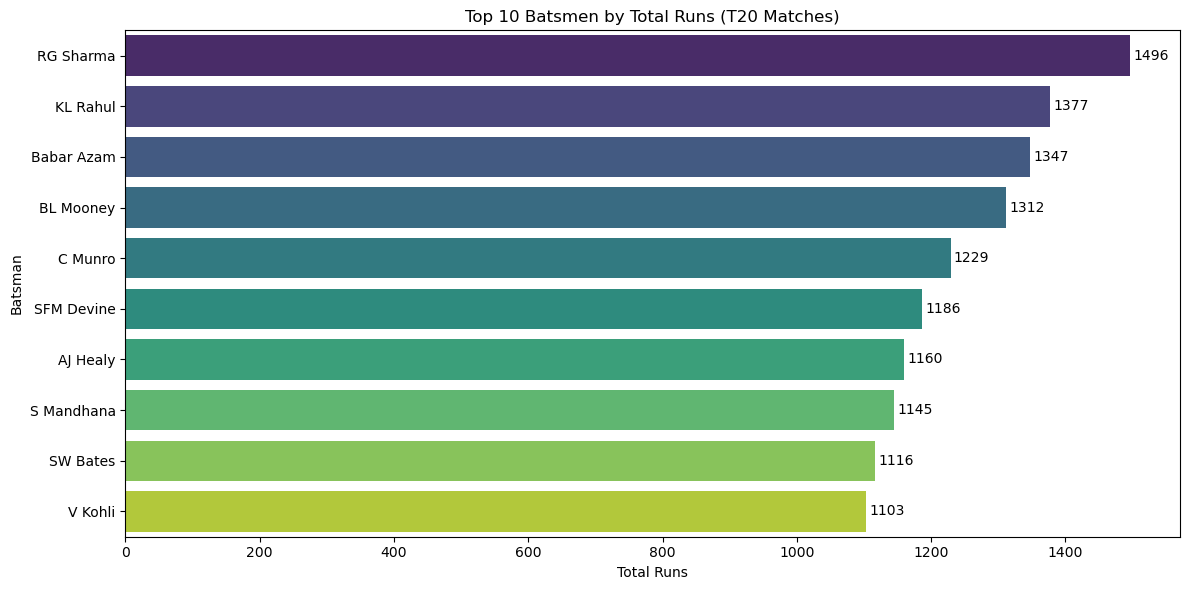

In [8]:
#1. Top 10 Batsmen by Runs (Bar Plot)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Connect to database and load batting data
conn = sqlite3.connect('cricket.db')

try:
    # Load batting data from t20_batting table
    batting_df = pd.read_sql("SELECT batsman, runs FROM t20_batting", conn)
    
    # 2. Get top 10 batsmen
    top_batsmen = batting_df.groupby('batsman')['runs'].sum().nlargest(10).reset_index()
    
    # 3. Create the visualization
    plt.figure(figsize=(12,6))
    sns.barplot(
        x='runs', 
        y='batsman', 
        hue='batsman',
        data=top_batsmen, 
        palette='viridis',
        legend=False
    )
    plt.title('Top 10 Batsmen by Total Runs (T20 Matches)')
    plt.xlabel('Total Runs')
    plt.ylabel('Batsman')
    
    # Add value labels on each bar
    for index, value in enumerate(top_batsmen['runs']):
        plt.text(value + 5, index, str(value), va='center')
    
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error: {e}")
finally:
    conn.close()

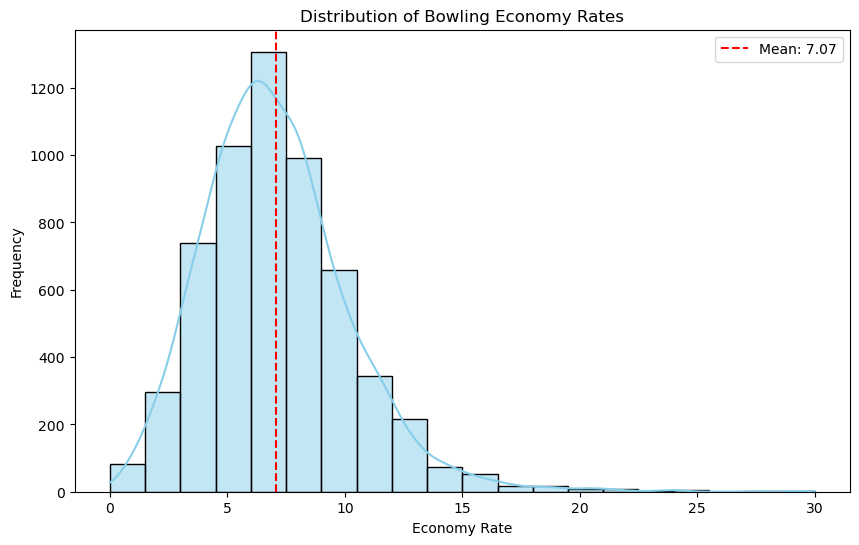

In [9]:
#2. Distribution of Bowling Economy Rates (Histogram)
# 1. Connect to database and load bowling data
conn = sqlite3.connect('cricket.db')
bowling_df = pd.read_sql("SELECT economy FROM t20_bowling", conn)
conn.close()

# 2. Create the visualization
plt.figure(figsize=(10,6))
sns.histplot(bowling_df['economy'], bins=20, kde=True, color='skyblue')

# Add mean line and labels
mean_economy = bowling_df['economy'].mean()
plt.axvline(mean_economy, color='red', linestyle='--', 
            label=f'Mean: {mean_economy:.2f}')

plt.title('Distribution of Bowling Economy Rates')
plt.xlabel('Economy Rate')
plt.ylabel('Frequency')
plt.legend()
plt.show()

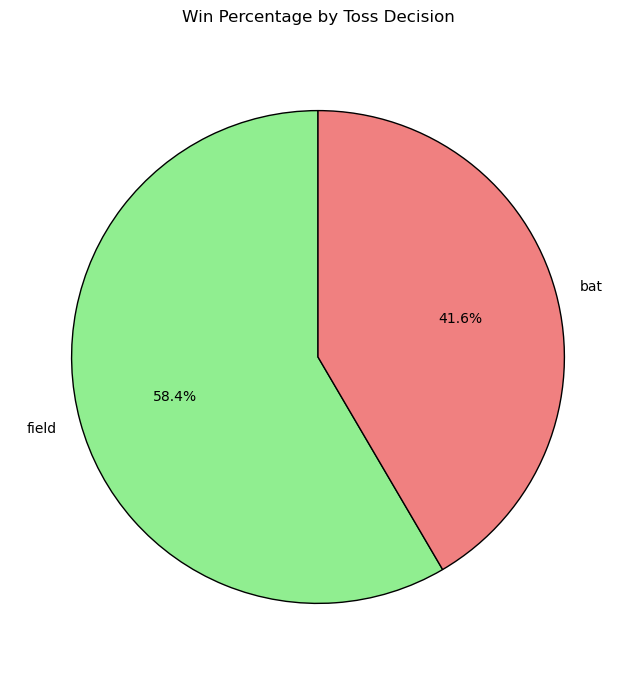

In [10]:
#3. Win Percentage by Toss Decision (Pie Chart)
# 1. Connect to database and load matches data
conn = sqlite3.connect('cricket.db')
matches_df = pd.read_sql("SELECT * FROM t20_matches", conn)
conn.close()

# 2. Calculate win percentages by toss decision
toss_wins = matches_df[matches_df['toss_winner'] == matches_df['winner']]
win_percentages = toss_wins['toss_decision'].value_counts(normalize=True) * 100

# 3. Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(win_percentages, 
        labels=win_percentages.index, 
        autopct='%1.1f%%',
        colors=['lightgreen', 'lightcoral'],
        startangle=90,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1})

plt.title('Win Percentage by Toss Decision', pad=20)
plt.show()

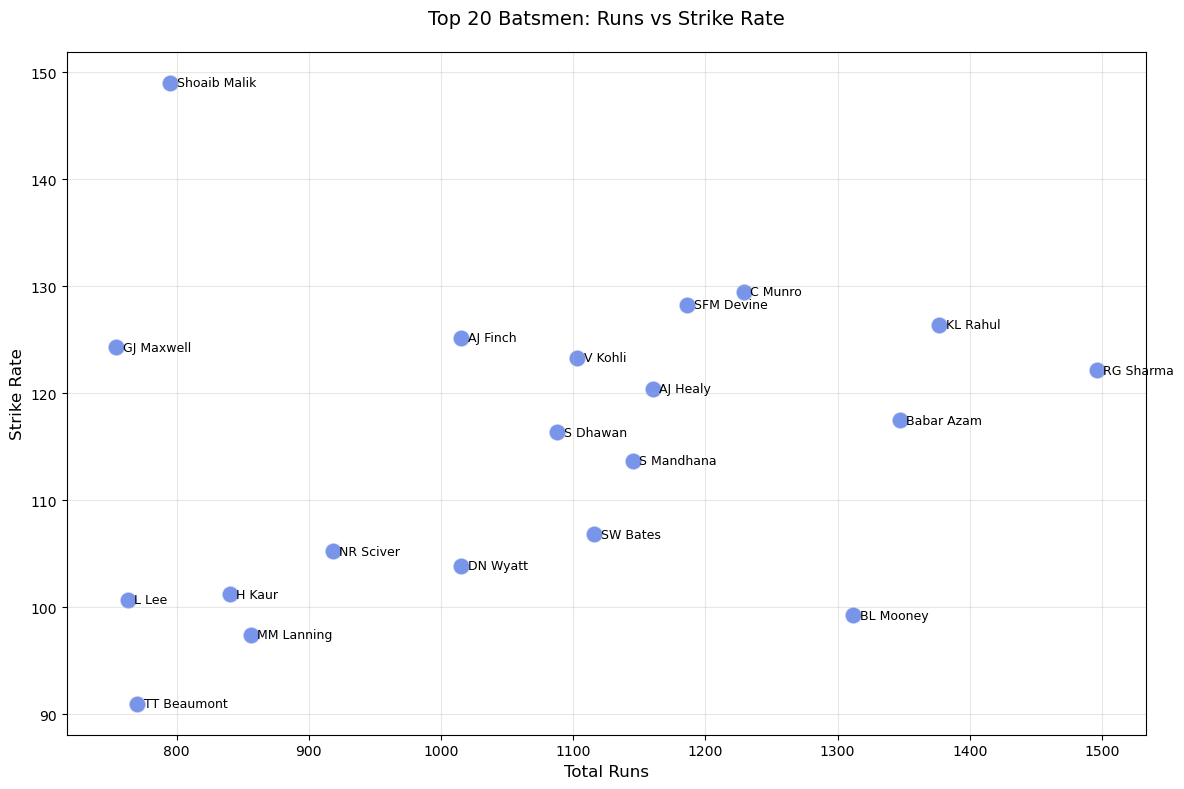

In [11]:
#4. Runs vs Strike Rate for Top Batsmen (Scatter Plot)
# 1. Connect to database and load batting data
conn = sqlite3.connect('cricket.db')
batting_df = pd.read_sql("SELECT * FROM t20_batting", conn)
conn.close()

# 2. Calculate batting stats - with error handling
try:
    # Option 1: If strike_rate column exists
    batting_stats = batting_df.groupby('batsman').agg(
        total_runs=('runs', 'sum'),
        strike_rate=('strike_rate', 'mean')
    ).nlargest(20, 'total_runs')
except KeyError:
    # Option 2: Calculate strike rate if balls column exists
    if 'balls' in batting_df.columns:
        batting_stats = batting_df.groupby('batsman').agg(
            total_runs=('runs', 'sum'),
            total_balls=('balls', 'sum')
        )
        batting_stats['strike_rate'] = (batting_stats['total_runs'] / batting_stats['total_balls']) * 100
        batting_stats = batting_stats.nlargest(20, 'total_runs')
    else:
        # Option 3: Fallback to just runs if no strike rate data available
        batting_stats = batting_df.groupby('batsman')['runs'].sum().nlargest(20).reset_index()
        batting_stats['strike_rate'] = 0  # Dummy value

# 3. Create the visualization
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(
    data=batting_stats,
    x='total_runs',
    y='strike_rate',
    s=150,
    color='royalblue',
    alpha=0.7
)

plt.title('Top 20 Batsmen: Runs vs Strike Rate', fontsize=14, pad=20)
plt.xlabel('Total Runs', fontsize=12)
plt.ylabel('Strike Rate', fontsize=12)

# Add player names as annotations if we have strike rate data
if 'strike_rate' in batting_stats.columns and (batting_stats['strike_rate'] > 0).any():
    for i, row in batting_stats.iterrows():
        ax.text(
            row['total_runs'] + 5,
            row['strike_rate'],
            i,
            fontsize=9,
            ha='left',
            va='center'
        )

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

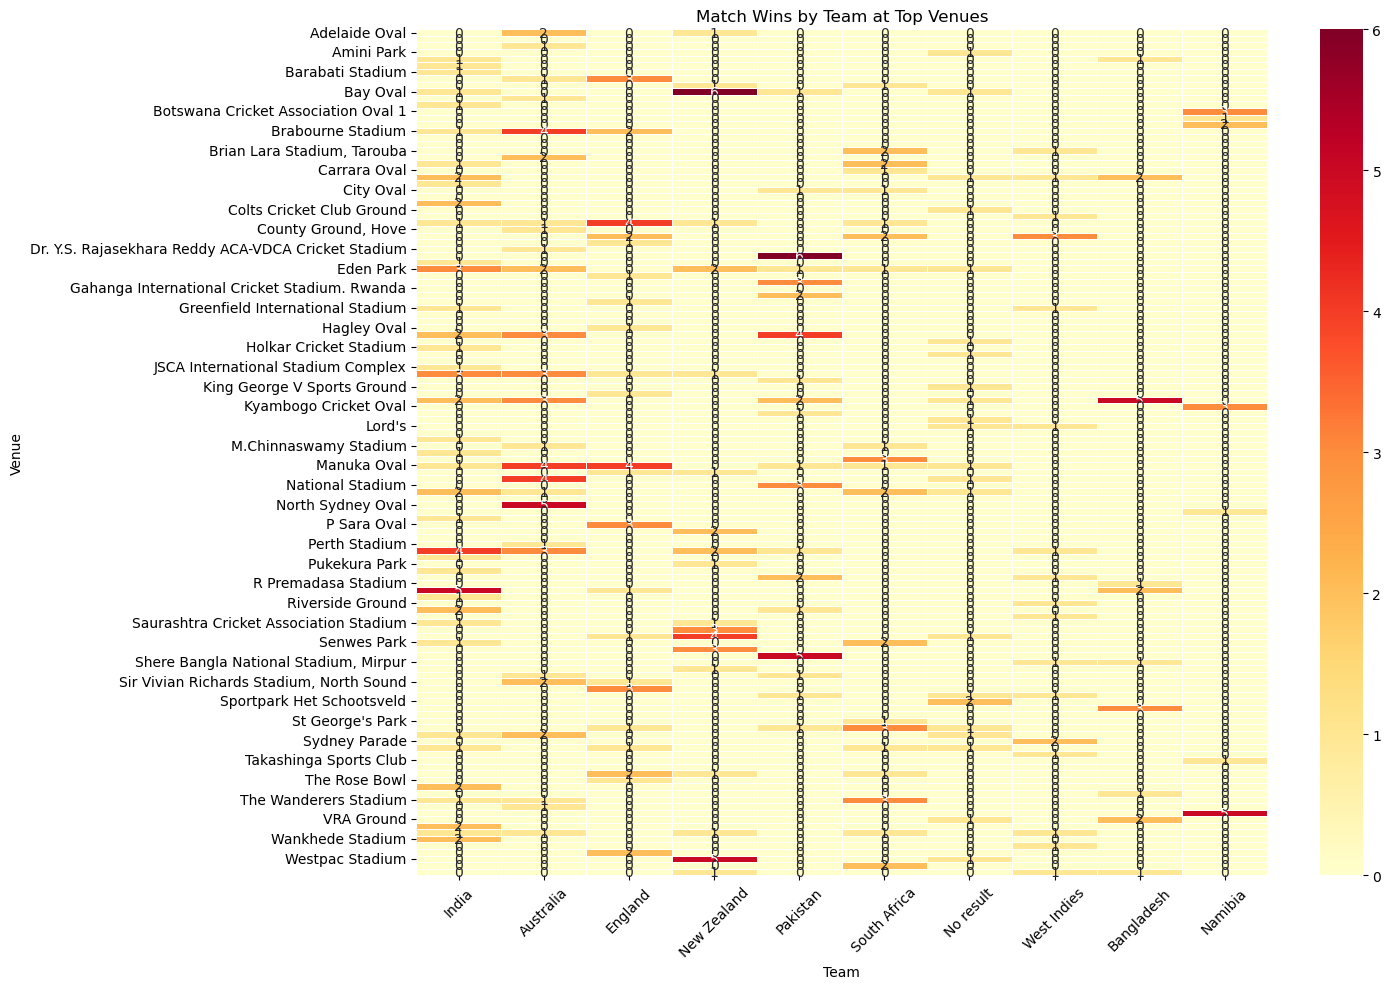

In [12]:

#5.Bonus: Match Results by Venue (Heatmap)

# Prepare data
venue_results = matches_df.groupby(['venue', 'winner']).size().unstack().fillna(0)

plt.figure(figsize=(15,10))
sns.heatmap(venue_results[venue_results.sum().nlargest(10).index], 
            cmap='YlOrRd', annot=True, fmt='g', linewidths=0.5)
plt.title('Match Wins by Team at Top Venues')
plt.xlabel('Team')
plt.ylabel('Venue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

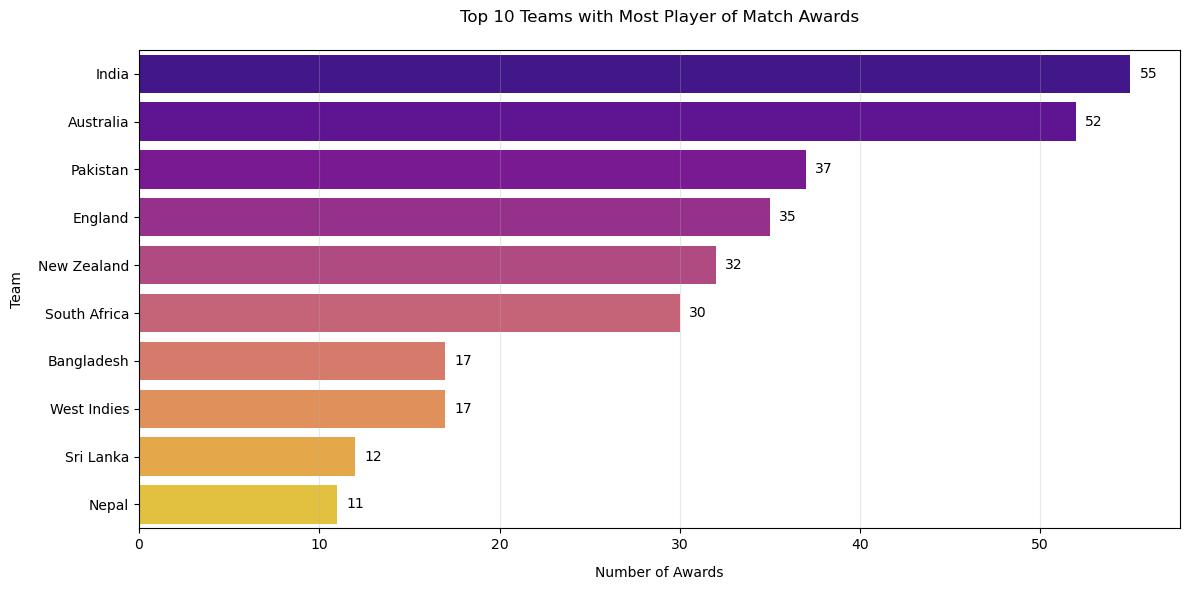

In [13]:
#6.Player of Match Awards Distribution by Team
plt.figure(figsize=(12,6))

# Get top 10 teams by player of match awards
awards_by_team = (matches_df[matches_df['player_of_match'] != '']
                 .groupby('winner')['player_of_match']
                 .count()
                 .nlargest(10))

# Create the plot with corrected parameters
ax = sns.barplot(x=awards_by_team.values,
                y=awards_by_team.index,
                hue=awards_by_team.index,  # Added hue parameter
                palette='plasma',
                legend=False)  # Disabled legend since it's redundant

# Add value labels
for i, v in enumerate(awards_by_team.values):
    ax.text(v + 0.5, i, str(v), color='black', va='center')

plt.title('Top 10 Teams with Most Player of Match Awards', pad=20)
plt.xlabel('Number of Awards', labelpad=10)
plt.ylabel('Team', labelpad=10)
plt.grid(axis='x', alpha=0.3)

# Adjust layout to prevent cutoff
plt.tight_layout()
plt.show()

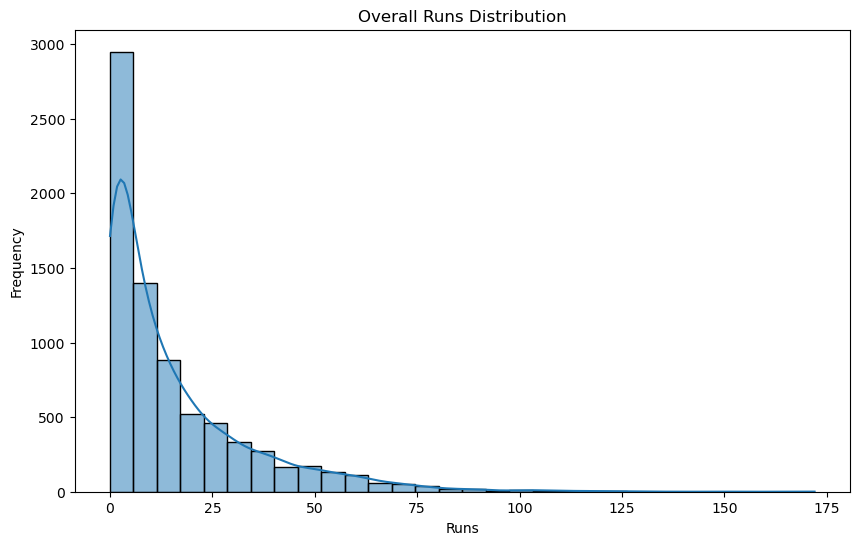

In [14]:
#7.Runs Distribution in Powerplay (Overs 1-6) vs Death Overs (16-20)

def plot_runs_distribution(batting_df):
    """Flexible function to plot runs distribution based on available data"""
    
    # Option 1: If over-by-over data exists
    if 'over' in batting_df.columns:
        batting_df['phase'] = batting_df['over'].apply(
            lambda x: 'Powerplay' if x <= 6 else ('Death' if x >= 16 else 'Middle'))
        
        plt.figure(figsize=(10,6))
        sns.boxplot(data=batting_df, x='phase', y='runs', 
                   order=['Powerplay','Middle','Death'],
                   palette='Set2')
        plt.title('Runs Distribution by Match Phase')
        plt.xlabel('Match Phase')
        plt.ylabel('Runs per Dismissal')
        plt.show()
        
    # Option 2: If innings data exists
    elif 'innings' in batting_df.columns:
        plt.figure(figsize=(10,6))
        sns.boxplot(data=batting_df, x='innings', y='runs', palette='Set3')
        plt.title('Runs Distribution by Innings')
        plt.xlabel('Innings')
        plt.ylabel('Runs')
        plt.show()
        
    # Option 3: Basic distribution
    else:
        plt.figure(figsize=(10,6))
        sns.histplot(batting_df['runs'], bins=30, kde=True)
        plt.title('Overall Runs Distribution')
        plt.xlabel('Runs')
        plt.ylabel('Frequency')
        plt.show()

# Execute the function
plot_runs_distribution(batting_df)

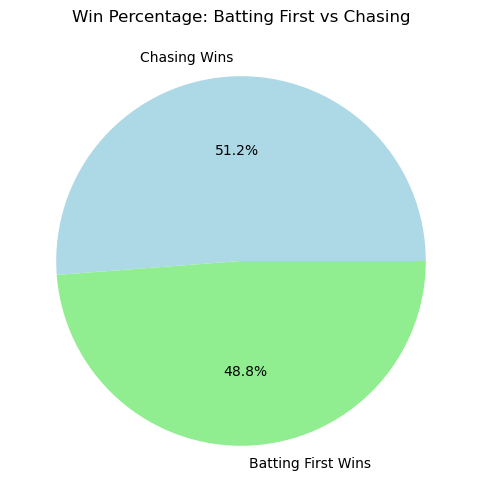

In [15]:
#8.Win Percentage When Batting First vs Chasing
matches_df['bat_first_win'] = matches_df.apply(lambda x: 1 if 
    ((x['toss_decision'] == 'bat' and x['toss_winner'] == x['winner']) or 
     (x['toss_decision'] == 'field' and x['toss_winner'] != x['winner'])) 
    else 0, axis=1)

win_percentage = matches_df['bat_first_win'].value_counts(normalize=True) * 100

plt.figure(figsize=(8,6))
win_percentage.plot(kind='pie', labels=['Chasing Wins','Batting First Wins'],
                    autopct='%1.1f%%', colors=['lightblue','lightgreen'])
plt.title('Win Percentage: Batting First vs Chasing')
plt.ylabel('')
plt.show()


Economy Rate Statistics:
- Mean: 7.07
- Median: 6.75
- Standard Deviation: 3.13
- Range: 0.00 to 30.00



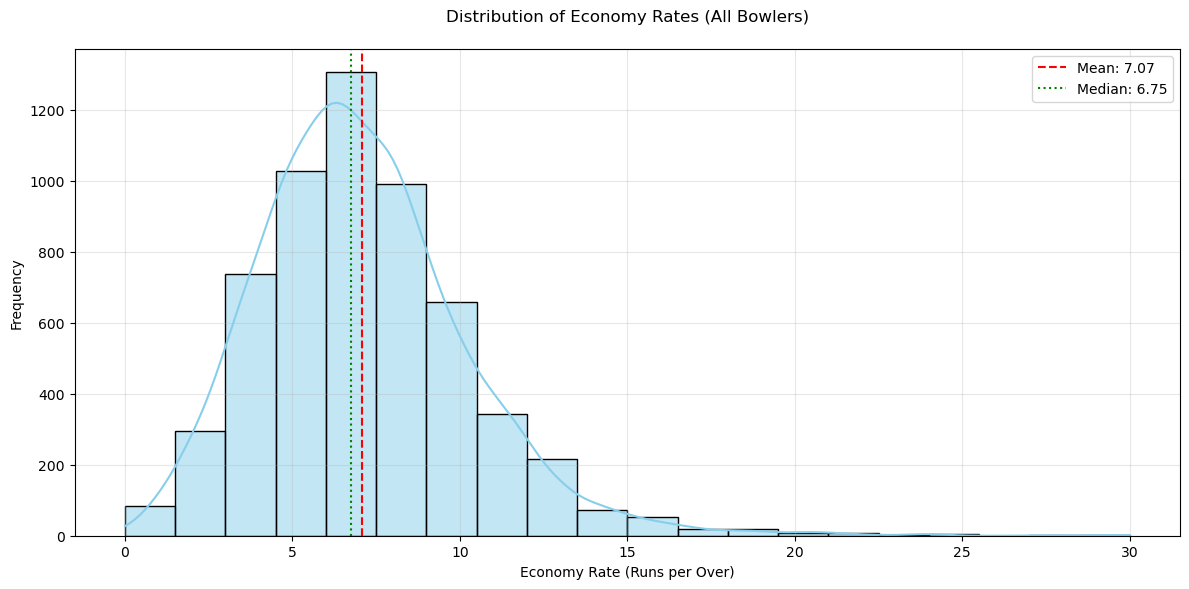

In [46]:

# 9.Basic economy rate analysis
plt.figure(figsize=(12, 6))

# Histogram with KDE
ax = sns.histplot(bowling_df['economy'], bins=20, kde=True, color='skyblue')

# Add statistical markers
mean_eco = bowling_df['economy'].mean()
median_eco = bowling_df['economy'].median()
ax.axvline(mean_eco, color='red', linestyle='--', label=f'Mean: {mean_eco:.2f}')
ax.axvline(median_eco, color='green', linestyle=':', label=f'Median: {median_eco:.2f}')

# Formatting
plt.title('Distribution of Economy Rates (All Bowlers)', pad=20)
plt.xlabel('Economy Rate (Runs per Over)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Print statistics
print(f"""
Economy Rate Statistics:
- Mean: {mean_eco:.2f}
- Median: {median_eco:.2f}
- Standard Deviation: {bowling_df['economy'].std():.2f}
- Range: {bowling_df['economy'].min():.2f} to {bowling_df['economy'].max():.2f}
""")

plt.show()

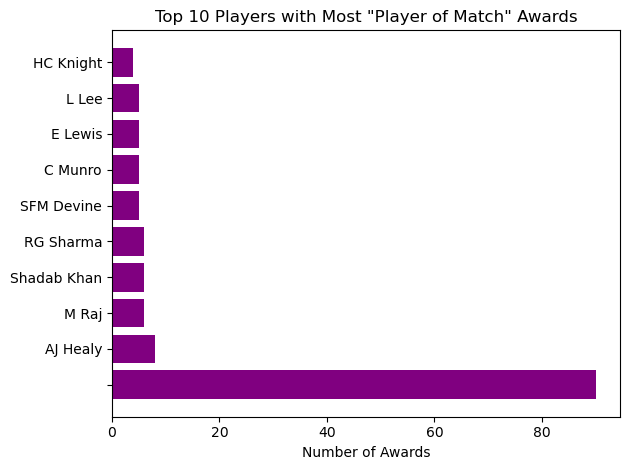

In [48]:

# 10.Player of Match Awards by Team
awards = matches_df['player_of_match'].value_counts().nlargest(10)
plt.barh(awards.index, awards.values, color='purple')
plt.title('Top 10 Players with Most "Player of Match" Awards')
plt.xlabel('Number of Awards')
plt.tight_layout()
plt.show()


In [9]:
df = pd.read_csv("t20_data.csv")  # or pd.read_excel(), etc.

FileNotFoundError: [Errno 2] No such file or directory: 't20_data.csv'